# Comparaison des performances entre Vision Transformers (ViT) et Convolutional Neural Networks (CNN) pour la classification d’images

---

## Objectif principal
Le but de ce notebook est de comparer les performances de deux architectures récentes, Vision Transformers (ViT) et Convolutional Neural Networks (CNN), sur des tâches de classification d'images. 

## Organisation du notebook
 
Nous commençons notre étude par la description et la visualision des datasets utilisés tout en justifiant le choix de ces derniers. 

Ensuite nous entrainerons et testerons les deux architectures from scratch sur nos datasets. 

Puis nous comparerons les performances des deux modèles en prenant en compte les performances de classification, de temps d'entainement, de puissance de calcul et de mémoire.

Enfin, nous comparerons de la même façon ces deux architectures pré-entraînés sur ImageNet.

Nous utilisons la librairie pytorch pour ce notebook.

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Choix des datasets

Nous allons prendre les datasets **CIFAR-10** et **Hymenotera**.

## Description des datasets utilisés

| Dataset | Description | Taille des images | Nombre de classes | Exemples de classes | Nombre d'images
| :--- | :--- | :--- | :--- | :--- | :--- |
| **CIFAR-10** | Dataset d'images couleur d'objets divers, plus complexe et varié que MNIST. | 32x32 pixels | 10 | Avion, Voiture, Oiseau, Chat, Cerf, Chien, Grenouille, Cheval, Bateau, Camion | 60 000 |
| **Hymenoptera** | Fourmis vs Abeilles. | 224x224 pixels | 2 | Fourmis, Abeilles | 400 |


- CIFAR-10 : disponible directement avec torch.
- Hymenoptera :est disponible ici https://www.kaggle.com/datasets/thedatasith/hymenoptera.

Le premier dataset, CIFAR-10, est un jeu de données largement utilisé dans la littérature pour la classification d’images. Il est composé d’images de basse résolution et reste relativement petit, avec 60 000 images. Le second dataset, Hymenoptera, est quant à lui constitué d’images de haute résolution, mais sa taille est largement inférieure, avec seulement 400 images.
L’utilisation de ces deux datasets nous permettra d’évaluer les performances des deux architectures sur des images de faible et haute résolution. Cela offrira également l’opportunité de comparer leur robustesse lorsqu’elles sont entraînées sur un nombre limité de données.



In [ ]:
## Import des fonctions nécessaires définies dans les différents fichier python
import prepa_dataset
import train
import Test_functions
from Test_functions import get_predictions, compute_accuracy, plot_confusion_matrix
import Custom_ResNet
import Custom_ViT
import Compare


## Préparation des données

### Préparation de Hymenoptera

In [3]:
import kagglehub
import os
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/neboit/.conda/envs/vit_min/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
path_hymenoptera = kagglehub.dataset_download("thedatasith/hymenoptera")+"/hymenoptera"

print("Path to hymenoptera dataset files:", path_hymenoptera)

train_path_hymenoptera = os.path.join(path_hymenoptera, 'train')
test_path_hymenoptera = os.path.join(path_hymenoptera, 'val')

Path to hymenoptera dataset files: /home/davodeau/.cache/kagglehub/datasets/thedatasith/hymenoptera/versions/5/hymenoptera


In [6]:
# Transformation pour Hymenoptera car taille des images variées
hym_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
#Chargement des données
x_train, y_train, class_names_hym = prepa_dataset.load_folder_to_tensors(train_path_hymenoptera, hym_transforms)
x_test, y_test, class_names_hym = prepa_dataset.load_folder_to_tensors(test_path_hymenoptera, hym_transforms)


Afin de respecter une la répartition 80% train, 10% val et 10% test nous rassemblons les données pour ensuite créer les datasets avec la bonne répartition.
Nous vérifions également que toutes les classes soient distribuées équitablement dans chaque échantillon.

In [ ]:
#Utilise torch.cat car les données sont des tensors
x_total = torch.cat([x_train, x_test], dim=0)
y_total = torch.cat([y_train, y_test], dim=0)

print(f"Nombre total d'images: {len(x_total)}")


# Division 1
x_train_hymenoptera, x_transition, y_train_hymenoptera, y_transition = train_test_split(
    x_total, y_total, 
    test_size=0.2,  
    random_state=42,
    stratify=y_total  # Maintient la distribution des classes
)

# Division 2
x_val_hymenoptera, x_test_hymenoptera, y_val_hymenoptera, y_test_hymenoptera = train_test_split(
    x_transition, y_transition,
    test_size=0.5,  
    random_state=42,
    stratify=y_transition
)


print(f"Train: {len(x_train_hymenoptera)} images")
print(f"Validation: {len(x_val_hymenoptera)} images ")
print(f"Test: {len(x_test_hymenoptera)} images")


print(f"\nDistribution des classes dans train: {np.bincount(y_train_hymenoptera)}")
print(f"Distribution des classes dans validation: {np.bincount(y_val_hymenoptera)}")
print(f"Distribution des classes dans test: {np.bincount(y_test_hymenoptera)}")


Nombre total d'images: 397
Train: 317 images
Validation: 40 images 
Test: 40 images

Distribution des classes dans train: [154 163]
Distribution des classes dans validation: [19 21]
Distribution des classes dans test: [20 20]


### Préparation de CIFAR-10

In [ ]:
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    transform=cifar_transforms,
    download=True
)

test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=cifar_transforms,
    download=True
)

val_ratio = 0.2
n_total = len(full_train_dataset)
n_val = int(val_ratio * n_total)
n_train = n_total - n_val
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [n_train, n_val]
)


x_train_cifar10 = torch.stack([data[0] for data in train_dataset])
y_train_cifar10 = torch.tensor([data[1] for data in train_dataset])

x_val_cifar10 = torch.stack([data[0] for data in val_dataset])
y_val_cifar10 = torch.tensor([data[1] for data in val_dataset])

x_test_cifar10 = torch.stack([data[0] for data in test_dataset])
y_test_cifar10 = torch.tensor([data[1] for data in test_dataset])

print(x_train_cifar10.shape)
print(x_val_cifar10.shape)
print(x_test_cifar10.shape)

cifar_classes = full_train_dataset.classes

torch.Size([40000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


### Découpage des datasets en batches de taille 64 et changement du type pour la crossentropy

In [ ]:
#Transformation en data loader avec des batches de taille 64
def get_dataloaders(x, y, batch_size=64, shuffle=True):
    if not isinstance(y, torch.LongTensor):
        y = y.long()
        
    dataset = TensorDataset(x, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader


train_loader_cifar = get_dataloaders(x_train_cifar10, y_train_cifar10, batch_size=64, shuffle=True)
val_loader_cifar   = get_dataloaders(x_val_cifar10, y_val_cifar10, batch_size=64, shuffle=False)
test_loader_cifar   = get_dataloaders(x_test_cifar10, y_test_cifar10, batch_size=64, shuffle=False)

train_loader_hym = get_dataloaders(x_train_hymenoptera, y_train_hymenoptera, batch_size=32, shuffle=True)
val_loader_hym   = get_dataloaders(x_val_hymenoptera, y_val_hymenoptera, batch_size=32, shuffle=False)
test_loader_hym   = get_dataloaders(x_test_hymenoptera, y_test_hymenoptera, batch_size=32, shuffle=False)

# Visualisation des datasets

### hymenoptera

----- Dataset Description -----
Train data: 317 images
Dimensions détectées : 224x224 pixels, 3 canaux
Format PyTorch (Channels First) : Oui
Number of classes: 2
--------------------------------


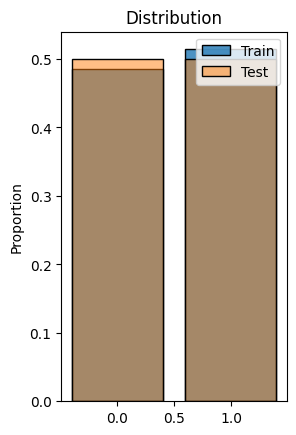

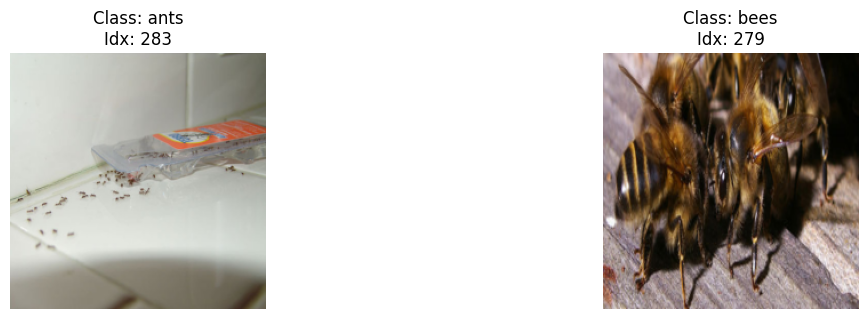

In [10]:
prepa_dataset.describe_image_dataset(
    x_train_hymenoptera, y_train_hymenoptera,
    x_test_hymenoptera, y_test_hymenoptera,
    class_names=class_names_hym,
    cmap=None
)

### CIFAR-10

----- Dataset Description -----
Train data: 40000 images
Dimensions détectées : 32x32 pixels, 3 canaux
Format PyTorch (Channels First) : Oui
Number of classes: 10
--------------------------------


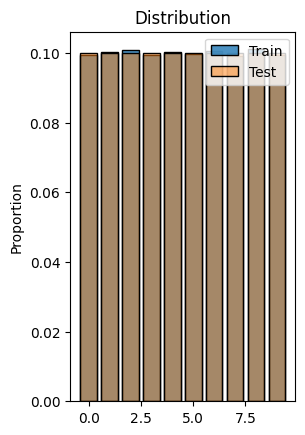

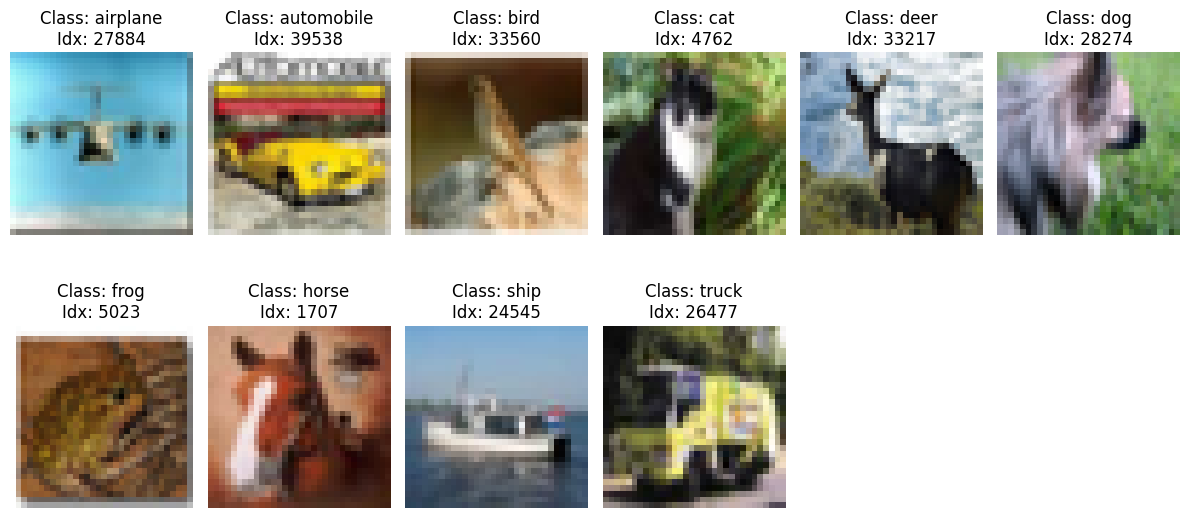

In [11]:
prepa_dataset.describe_image_dataset(
    x_train_cifar10, y_train_cifar10,
    x_test_cifar10, y_test_cifar10,
    class_names=cifar_classes,
    cmap=None
)

# Convolutional Neural Network (CNN or ConvNet)

Nous allons commencer par la classification avec l'architecture CNN.

## Data format

L'architecture de convolution prend en entrée des **images** et non des vecteurs 1D. Un certain formatage des données reste nécessaire.

Une **troisième dimension** est requise : la dimension des **canaux** (ou *channels*), qui permet de décrire chaque pixel.
- Pour les images en couleur, chaque pixel est codé par **plusieurs valeurs** (canaux **RGB** : Rouge, Vert, Bleu).

Ainsi, il est nécessaire de **redimensionner** les images :
- Pour CIFAR-10 : passer d'une dimension **$32 \times 32$** à **$32 \times 32 \times 3$** (pour inclure les 3 canaux RGB)
- Pour Hymenoptera : passer d'une dimension **$224 \times 224$** à **$224 \times 224 \times 3$** (pour inclure les 3 canaux RGB)

## Achitecture pour des images de couleurs

### Architecture du Modèle : Custom ResNet

Pour améliorer les performances et la stabilité de l'apprentissage par rapport à un CNN séquentiel classique (type VGG), nous implémentons une architecture basée sur **ResNet (Residual Network)**.

#### 1. Le Bloc Résiduel (`ResidualBlock`)
L'innovation principale de cette architecture est l'introduction de **connexions résiduelles** (skip connections). Au lieu d'empiler simplement des couches de convolution, chaque bloc ajoute l'entrée originale $x$ à la sortie des convolutions $F(x)$ :

$$\text{Output} = \text{ReLU}(F(x) + x)$$

Cette technique permet :
* De combattre le problème de **disparition du gradient** (vanishing gradient) dans les réseaux profonds.
* D'apprendre plus facilement l'identité si une couche n'est pas nécessaire.


<img src="Images/ResBlock.png" alt="Description" width="300"/>

#### 2. Structure du `ResNetCustom`
Le réseau est structuré en 4 étapes principales augmentant progressivement la complexité sémantique (profondeur) tout en réduisant la dimension spatiale :

* **Initialisation :** Convolution $3 \times 3$ (64 filtres).
* **Layer 1 :** 64 filtres (taille spatiale inchangée).
* **Layer 2 :** 128 filtres (downsampling / 2).
* **Layer 3 :** 256 filtres (downsampling / 2).
* **Layer 4 :** 512 filtres (downsampling / 2).

#### 3. Adaptabilité Universelle (`AdaptiveAvgPool2d`)
Une spécificité importante de cette implémentation est l'utilisation de l'**Adaptive Average Pooling** en fin de réseau.
* Contrairement à un `Flatten` classique qui dépend de la taille d'entrée, cette couche force la sortie spatiale à **$1 \times 1$**, quelle que soit la taille de l'image en entrée.
* **Conséquence :** Ce même modèle peut être entraîné indifféremment sur **CIFAR-10** ($32 \times 32$ px) ou **Hymenoptera** ($224 \times 224$ px) sans modifier la couche linéaire finale (`fc`).


<img src="Images/ResNet.jpg" alt="Réseau type ResNet" width="1000"/>

Schéma généré par IA. 


## Entrainement CNN sur les deux datasets

Pour plus de lisibilité nous avons déclaré la classe *ResNetCustom* dans le fichier **Custom_ResNet.py**

### 1er entrainement: CIFAR10

In [ ]:
criterion = nn.CrossEntropyLoss()
model_resnet_cifar = Custom_ResNet.ResNetCustom(num_classes=10).to(device)

optimizer_cifar = torch.optim.Adam(model_resnet_cifar.parameters(), lr=0.001)
num_epochs_cifar = 10  
history_cifar = train.train_model(
    model=model_resnet_cifar,
    train_loader=train_loader_cifar,
    val_loader=val_loader_cifar,
    criterion=criterion,
    optimizer=optimizer_cifar,
    num_epochs=num_epochs_cifar, 
    device=device
)

Démarrage de l'entraînement sur cuda pour 10 epochs
Epoch [1/10] Train Loss: 1.4271 Acc: 0.4787 | Val Loss: 1.1365 Acc: 0.5870
Epoch [2/10] Train Loss: 0.9350 Acc: 0.6678 | Val Loss: 1.0351 Acc: 0.6484
Epoch [3/10] Train Loss: 0.6939 Acc: 0.7554 | Val Loss: 0.7872 Acc: 0.7191
Epoch [4/10] Train Loss: 0.5423 Acc: 0.8104 | Val Loss: 0.7836 Acc: 0.7453
Epoch [5/10] Train Loss: 0.4315 Acc: 0.8496 | Val Loss: 0.5681 Acc: 0.8127
Epoch [6/10] Train Loss: 0.3349 Acc: 0.8830 | Val Loss: 0.5353 Acc: 0.8230
Epoch [7/10] Train Loss: 0.2431 Acc: 0.9133 | Val Loss: 0.5825 Acc: 0.8200
Epoch [8/10] Train Loss: 0.1874 Acc: 0.9330 | Val Loss: 0.5810 Acc: 0.8294
Epoch [9/10] Train Loss: 0.1352 Acc: 0.9529 | Val Loss: 0.7019 Acc: 0.8119
Epoch [10/10] Train Loss: 0.1039 Acc: 0.9637 | Val Loss: 0.6897 Acc: 0.8242
Entraînement terminé en 3m 50s


### 2ème entrainement: Hymenoptera

In [ ]:
model_resnet_hym = Custom_ResNet.ResNetCustom(num_classes=2).to(device)

optimizer_hym = torch.optim.Adam(model_resnet_hym.parameters(), lr=0.001)
num_epochs_hym = 15  
history_hym = train.train_model(
    model=model_resnet_hym, 
    train_loader=train_loader_hym,
    val_loader=val_loader_hym,
    criterion=criterion,
    optimizer=optimizer_hym,
    num_epochs=num_epochs_hym,
    device=device
)

Démarrage de l'entraînement sur cuda pour 15 epochs
Epoch [1/15] Train Loss: 1.1209 Acc: 0.5079 | Val Loss: 0.8293 Acc: 0.4750
Epoch [2/15] Train Loss: 0.6619 Acc: 0.5931 | Val Loss: 0.9462 Acc: 0.4750
Epoch [3/15] Train Loss: 0.6274 Acc: 0.6562 | Val Loss: 0.7606 Acc: 0.5500
Epoch [4/15] Train Loss: 0.6102 Acc: 0.6877 | Val Loss: 0.8376 Acc: 0.6500
Epoch [5/15] Train Loss: 0.6147 Acc: 0.6782 | Val Loss: 0.7985 Acc: 0.5750
Epoch [6/15] Train Loss: 0.5686 Acc: 0.6909 | Val Loss: 0.7217 Acc: 0.6000
Epoch [7/15] Train Loss: 0.5726 Acc: 0.7003 | Val Loss: 0.7709 Acc: 0.6000
Epoch [8/15] Train Loss: 0.5714 Acc: 0.7161 | Val Loss: 0.7019 Acc: 0.7000
Epoch [9/15] Train Loss: 0.5566 Acc: 0.7003 | Val Loss: 0.7253 Acc: 0.6000
Epoch [10/15] Train Loss: 0.5581 Acc: 0.7319 | Val Loss: 0.7331 Acc: 0.6000
Epoch [11/15] Train Loss: 0.5466 Acc: 0.7319 | Val Loss: 0.6955 Acc: 0.6750
Epoch [12/15] Train Loss: 0.5583 Acc: 0.7098 | Val Loss: 0.7756 Acc: 0.6000
Epoch [13/15] Train Loss: 0.5331 Acc: 0.7256 

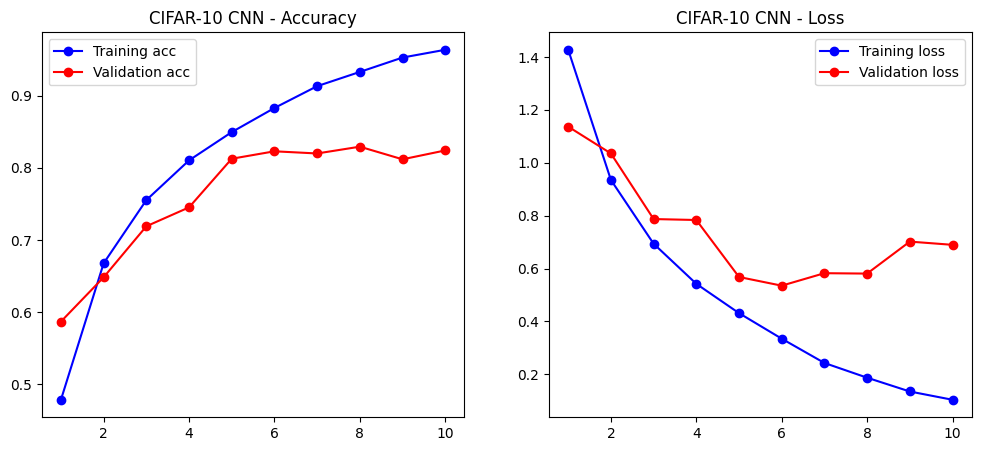

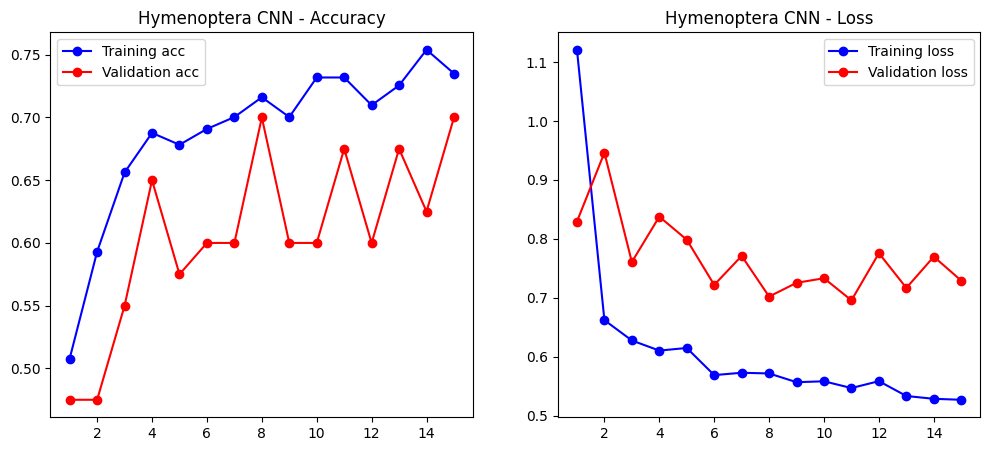

In [14]:
train.plot_history(history_cifar, title="CIFAR-10 CNN")
train.plot_history(history_hym, title="Hymenoptera CNN")

Pour le dataset CIFAR-10: Les courbes d'accuracy et loss pour l'échantillon d'entrainement et de validation montre que le modèle converge et généralise correctement, malgré un léger surapprentissage. La grande taille du jeu de données permet une optimisation stable.

Pour le dataset Hymenopetra: En observant les courbes d'accuracy et loss nous voyons des fluctuations indiquant que le modèle a du mal à généraliser, probablement en raison du manque de données.

## Test du CNN sur les deux datasets

Précision (Accuracy): 0.8166 (81.66%)


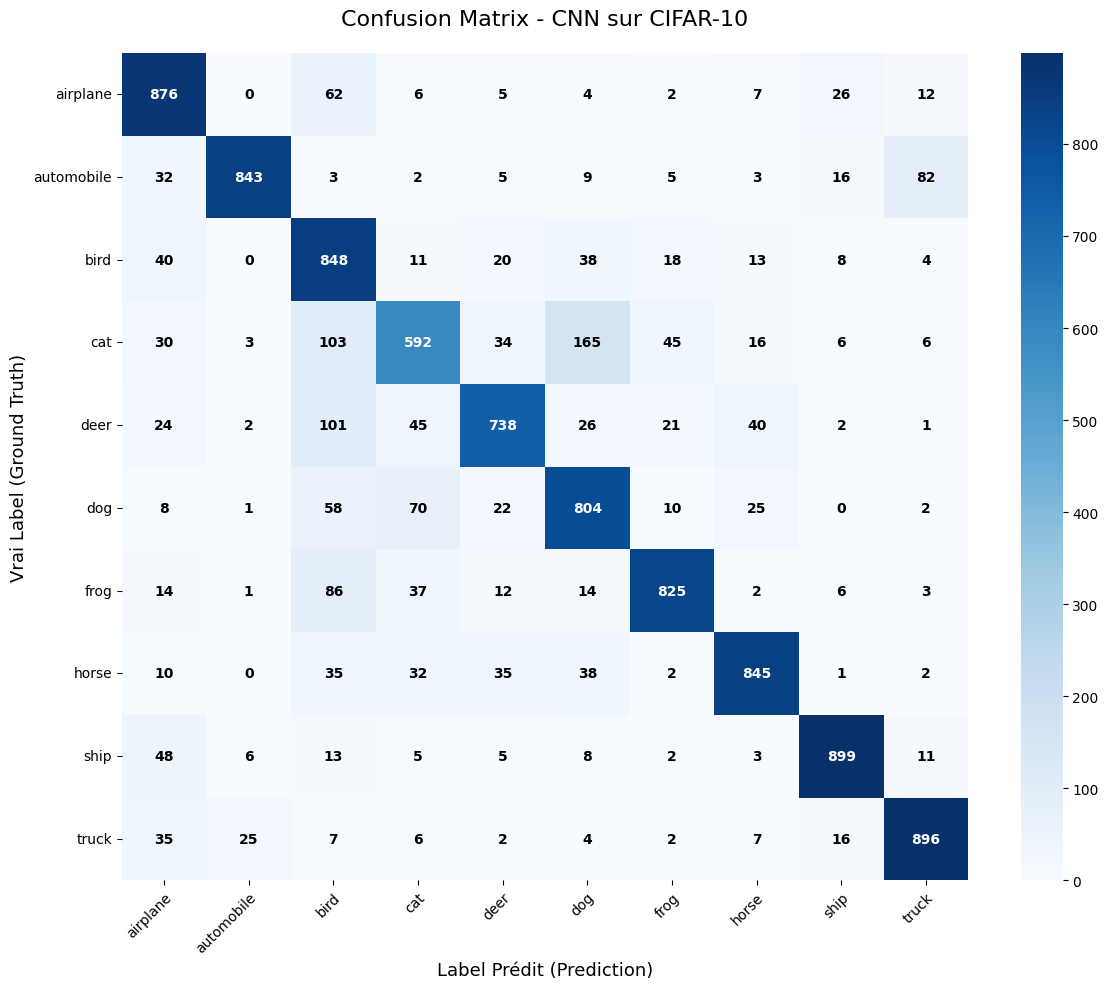

In [15]:
preds, labels = get_predictions(model_resnet_cifar, test_loader_cifar, device)

acc = compute_accuracy(labels, preds)

plot_confusion_matrix(labels, preds, cifar_classes, 
                      title="Confusion Matrix - CNN sur CIFAR-10")

Précision (Accuracy): 0.7500 (75.00%)


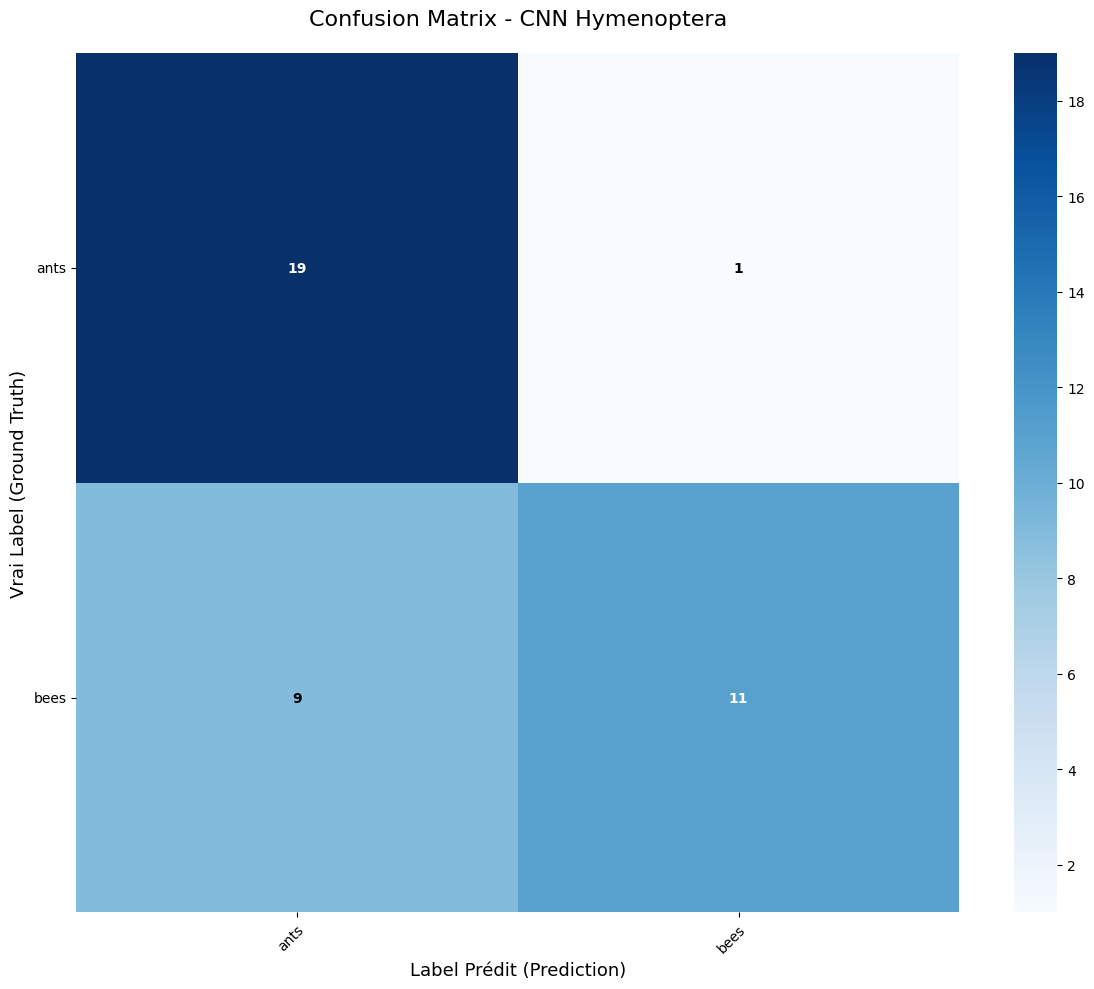

In [16]:
preds, labels = get_predictions(model_resnet_hym, test_loader_hym, device)

acc = compute_accuracy(labels, preds)

plot_confusion_matrix(labels, preds, class_names_hym, title="Confusion Matrix - CNN Hymenoptera")

# Modèle ViT
Nous allons maintenant nous concentrer sur l'architecture ViT.

## Compréhension du Vision Transformer (ViT)

Le ViT est une adaptation de l'architecture Transformer appliquée directement aux images. C'est une architecture Encoder-Only.


### 1: Embedding
L'image est découpée en patches contenant chacun les valeurs des pixels (ex: pour du RGB 16x16, on a 16 x16 x 3 valeurs). 
En suite chaque patch est aplati en un vecteur 1D puis projeté avec une couche linéaire pour obtenir un vecteur de dimension latente fixe.

### 2 : Le Token CLS 

Un vecteur apprenable est ajouté au début de la séquence de patchs. Son rôle est d'intégrer l'information de tous les autres tokens via le mécanisme de Self-Attention Multi-Head. C'est ce vecteur qui sera utilisé pour prédire la classe. 

### 3 : Positional Embeddings 

L'information spatiale est réintroduite en ajoutant un vecteur de position à chaque embedding de patch. Ce sont des paramètres appris durant l'entraînement qui permettent de donner la position des patchs.

### 4 Encodage avec le transformerblock
Une fois l'image convertie en une séquence de vecteurs de dimension latente, celle-ci traverse une série de blocs encoder répétés. 

D'abord, un mécanisme de Self-Attention Multi-head permet à chaque vecteur de la séquence de capter et d'intégrer l'information contenue dans tous les autres vecteurs. Ensuite, un MLP projette chaque vecteur individuellement.

Pour stabiliser l'apprentissage, les opérations sont précédées d'une normalisation et d'une connexion résiduelle (addition du vecteur d'entrée avec le vecteur de sortie).

### 5: Décision finale
À la sortie du dernier bloc encoder, on utilise uniquement le vecteur correspondant au Token CLS.

Ce vecteur réprésente l'information globale de l'image. Il est normalisé et ensuite projeté par une couche linéaire vers la dimension du nombre de classes, avant d'être converti en probabilités avec la fonction softmax.

Pour une meilleur compréhension, le schéma ci-dessous montre l'architecure typique de ViT reprenant les étapes énoncés (la dernière étape est condensé dans le block MLP Head)

<img src="Images/ViTAarchi.png" alt="Architecture ViT" width="1000"/>



## Entrainement du ViT sur les deux datasets

#### Déclaration des modèles

Pour plus de lisibilité nous avons déclaré la classe ViT dans le fichier **Custom_ViT.py**

La taille standard des patches est de 16x16 pixels, qui est optimisée pour des images haute résolution (224x224). Appliqué aux images de CIFAR-10 (32x32 pixels), ce découpage ne générerait que 4 patches (2×2), ce qui est insuffisant pour que le mécanisme d'attention capture des dépendances spatiales.

Il faut donc réduire la taille des patches à 4x4 afin d'avoir un meilleur apprentissage pour CIFAR10.

In [ ]:
print(f"Entraînement sur : {device}")

VIT_CONFIG = {
    'img_size': 224,      
    'patch_size': 16,     
    'embed_dim': 384,     
    'depth': 6,         
    'n_heads': 6,        
    'mlp_ratio': 4.0,
    'dropout': 0.1
}

VIT_CONFIG_cifar = {
    'img_size': 32,     
    'patch_size': 4,   
    'embed_dim': 128,     
    'depth': 6,           
    'n_heads': 4,         
    'mlp_ratio': 4.0,
    'dropout': 0.1
}

model_vit_cifar = Custom_ViT.ViT(
    **VIT_CONFIG_cifar,
    in_channels=3,
    n_classes=10
).to(device)

model_vit_hym = Custom_ViT.ViT(
    **VIT_CONFIG,
    in_channels=3,
    n_classes=2
).to(device)

print("Modèles ViT initialisés.")

Entraînement sur : cuda
Modèles ViT initialisés.


### Entrainement sur CIFAR10

In [ ]:
optimizer_vit_cifar = optim.AdamW(model_vit_cifar.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss()

history_vit_cifar = train.train_model(
        model=model_vit_cifar,
        train_loader=train_loader_cifar,
        val_loader=val_loader_cifar,
        criterion=criterion,
        optimizer=optimizer_vit_cifar,
        num_epochs=10, 
        device=device
    )

Démarrage de l'entraînement sur cuda pour 10 epochs
Epoch [1/10] Train Loss: 1.7860 Acc: 0.3442 | Val Loss: 1.5748 Acc: 0.4283
Epoch [2/10] Train Loss: 1.4782 Acc: 0.4666 | Val Loss: 1.3667 Acc: 0.5005
Epoch [3/10] Train Loss: 1.3037 Acc: 0.5281 | Val Loss: 1.2331 Acc: 0.5502
Epoch [4/10] Train Loss: 1.1986 Acc: 0.5694 | Val Loss: 1.1727 Acc: 0.5741
Epoch [5/10] Train Loss: 1.1233 Acc: 0.5979 | Val Loss: 1.1197 Acc: 0.5977
Epoch [6/10] Train Loss: 1.0686 Acc: 0.6162 | Val Loss: 1.0836 Acc: 0.6130
Epoch [7/10] Train Loss: 1.0202 Acc: 0.6363 | Val Loss: 1.0755 Acc: 0.6138
Epoch [8/10] Train Loss: 0.9771 Acc: 0.6503 | Val Loss: 1.0318 Acc: 0.6308
Epoch [9/10] Train Loss: 0.9386 Acc: 0.6649 | Val Loss: 1.0538 Acc: 0.6230
Epoch [10/10] Train Loss: 0.9040 Acc: 0.6787 | Val Loss: 1.0368 Acc: 0.6343
Entraînement terminé en 1m 52s
Modèle sauvegardé sous : vit_cifar10_weights.pth


### Entrainement sur Hymenoptera

In [ ]:
optimizer_vit_hym = optim.AdamW(model_vit_hym.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss()

history_vit_hym = train.train_model(
        model=model_vit_hym,
        train_loader=train_loader_hym,
        val_loader=val_loader_hym,
        criterion=criterion,
        optimizer=optimizer_vit_hym,
        num_epochs=10, 
        device=device
    )

Démarrage de l'entraînement sur cuda pour 10 epochs
Epoch [1/10] Train Loss: 0.8109 Acc: 0.5174 | Val Loss: 0.6927 Acc: 0.5750
Epoch [2/10] Train Loss: 0.6861 Acc: 0.5363 | Val Loss: 0.6864 Acc: 0.4750
Epoch [3/10] Train Loss: 0.6800 Acc: 0.5615 | Val Loss: 0.6866 Acc: 0.6000
Epoch [4/10] Train Loss: 0.6772 Acc: 0.5426 | Val Loss: 0.6837 Acc: 0.5750
Epoch [5/10] Train Loss: 0.6940 Acc: 0.5584 | Val Loss: 0.7184 Acc: 0.4750
Epoch [6/10] Train Loss: 0.6827 Acc: 0.5521 | Val Loss: 0.6850 Acc: 0.5500
Epoch [7/10] Train Loss: 0.6654 Acc: 0.6025 | Val Loss: 0.6991 Acc: 0.6000
Epoch [8/10] Train Loss: 0.6443 Acc: 0.6341 | Val Loss: 0.6579 Acc: 0.6250
Epoch [9/10] Train Loss: 0.6324 Acc: 0.6341 | Val Loss: 0.6271 Acc: 0.6000
Epoch [10/10] Train Loss: 0.5904 Acc: 0.7003 | Val Loss: 0.6144 Acc: 0.6750
Entraînement terminé en 0m 15s
Modèle sauvegardé sous : vit_Hymenoptera_weights.pth


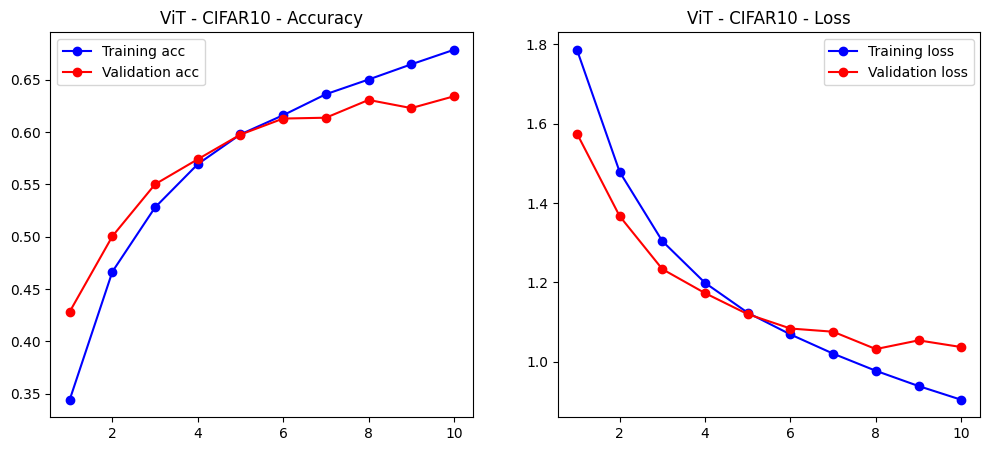

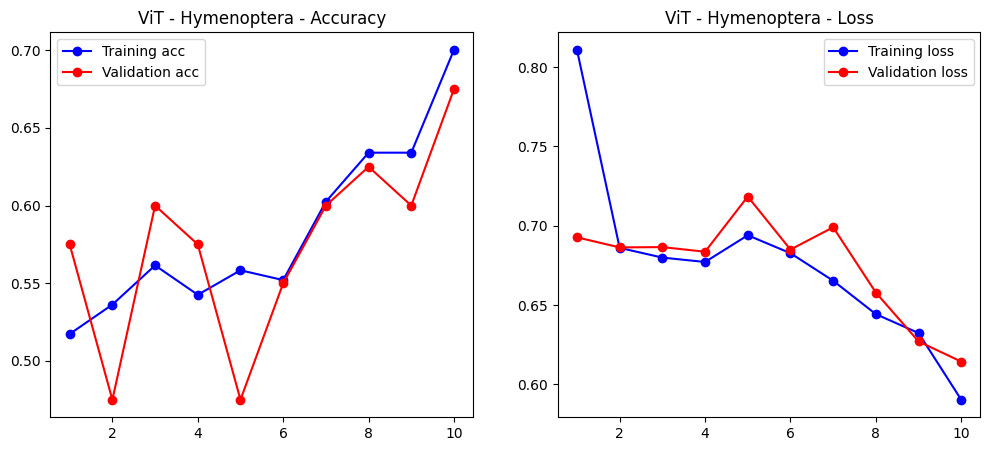

In [20]:
train.plot_history(history_vit_cifar, title="ViT - CIFAR10")
train.plot_history(history_vit_hym, title="ViT - Hymenoptera")

Les observations sont similaire à l'architecture CNN, avec néanmoins une accuracy plus faible pour CIFAR10. 

### Test du ViT sur les deux datasets 

Précision (Accuracy): 0.7500 (75.00%)


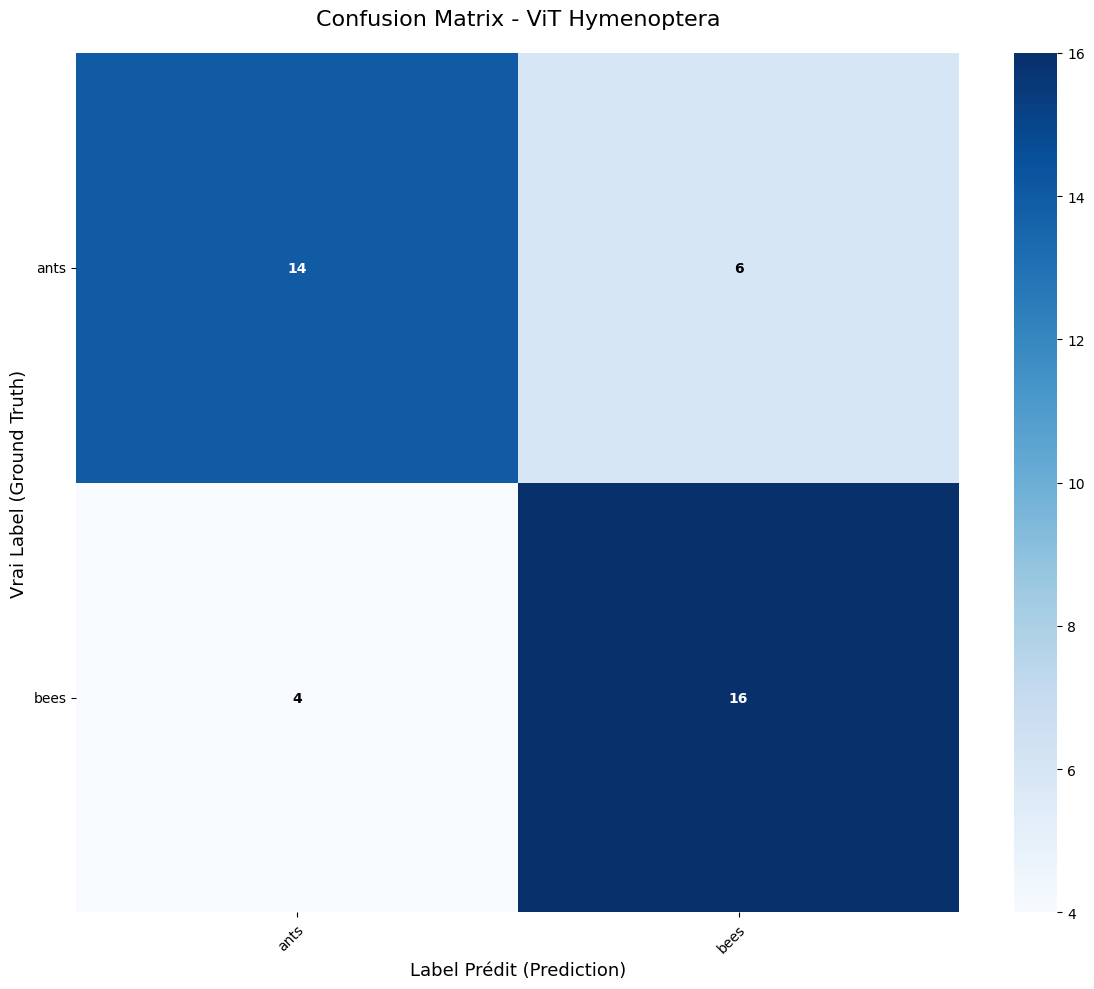

In [21]:
preds, labels = get_predictions(model_vit_hym, test_loader_hym, device)

acc = compute_accuracy(labels, preds)

plot_confusion_matrix(labels, preds, class_names_hym, title="Confusion Matrix - ViT Hymenoptera")

Précision (Accuracy): 0.6288 (62.88%)


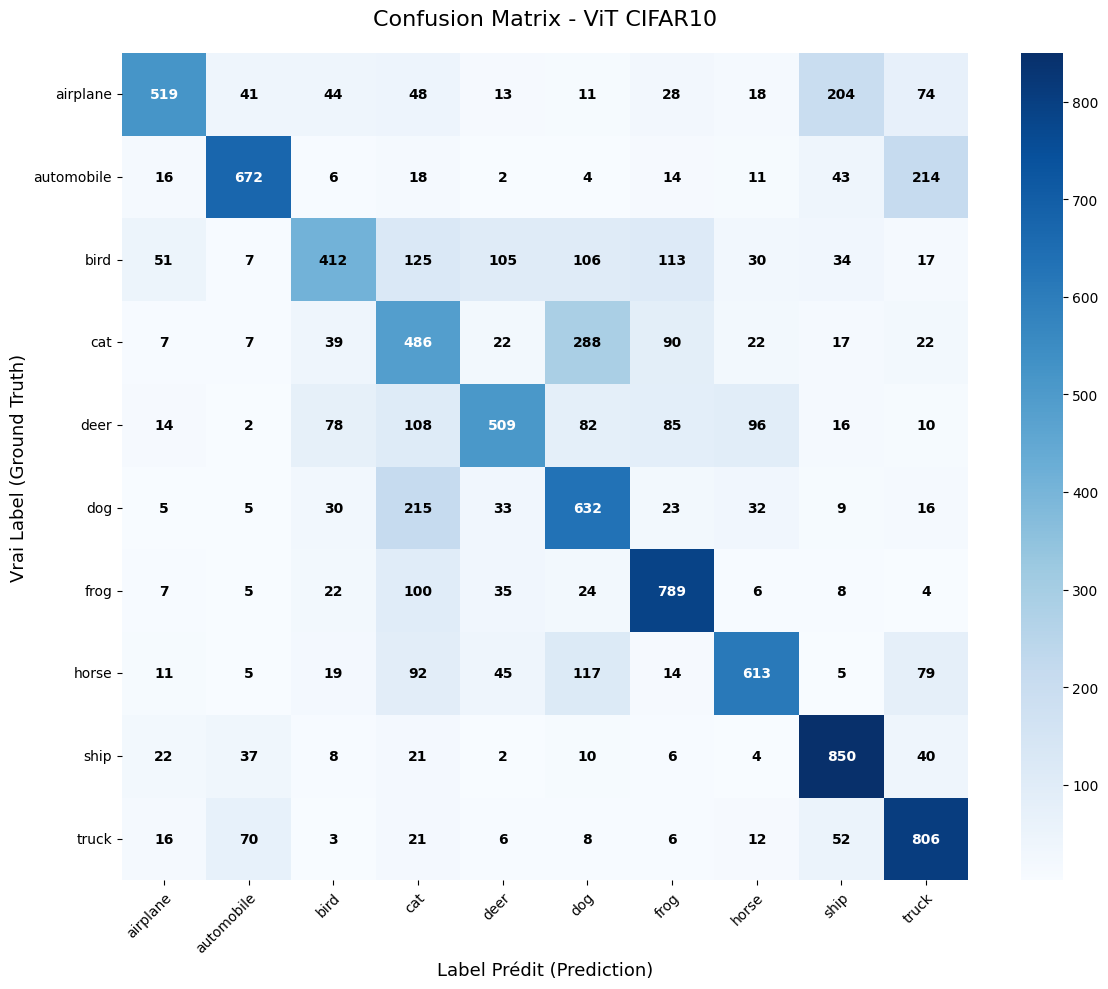

In [22]:
preds, labels = get_predictions(model_vit_cifar, test_loader_cifar, device)

acc = compute_accuracy(labels, preds)

plot_confusion_matrix(labels, preds, cifar_classes, title="Confusion Matrix - ViT CIFAR10")

# Comparaison des modèles

In [ ]:
# 1. Récupération des accuracies si pas trouvé met 0
def get_acc(var_name, local_vars):
    if var_name in local_vars:
        # On prend la dernière valeur de validation (val_acc)
        return local_vars[var_name]['val_acc'][-1]
    return 0.0

#Récupération des variables pour chaque modèle et dataset 

acc_resnet_cifar = get_acc('history_cifar', locals())
acc_resnet_hym   = get_acc('history_hym', locals())
acc_vit_cifar    = get_acc('history_vit_cifar', locals())
acc_vit_hym      = get_acc('history_vit_hym', locals())


print(f"Accuracies récupérées :")
print(f"CNN Cifar: {acc_resnet_cifar:.2%}")
print(f"CNN Hym  : {acc_resnet_hym:.2%}")
print(f"ViT Cifar: {acc_vit_cifar:.2%}")
print(f"ViT Hym  : {acc_vit_hym:.2%})")


# Modèles à comparer
models_dict = {
    'ResNet_CIFAR10': model_resnet_cifar,
    'ResNet_Hymenoptera': model_resnet_hym,
    'ViT_CIFAR10': model_vit_cifar,
    'ViT_Hymenoptera': model_vit_hym
}

# Input Shapes 
input_shapes_dict = {
    'ResNet_CIFAR10': (1, 3, 32, 32),
    'ResNet_Hymenoptera': (1, 3, 224, 224),
    'ViT_CIFAR10': (1, 3, 32, 32), 
    'ViT_Hymenoptera': (1, 3, 224, 224)
}

# Accuracies
accuracies_dict = {
    'ResNet_CIFAR10': acc_resnet_cifar,
    'ResNet_Hymenoptera': acc_resnet_hym,
    'ViT_CIFAR10': acc_vit_cifar,
    'ViT_Hymenoptera': acc_vit_hym
}

# Temps 
train_times_dict = {
    'ResNet_CIFAR10': 3*60+56.1, 'ResNet_Hymenoptera': 60+50.1,
    'ViT_CIFAR10': 34*60+47, 'ViT_Hymenoptera': 20.1
}

results = Compare.compare_models(
    models_dict=models_dict,
    input_shapes_dict=input_shapes_dict,
    accuracies_dict=accuracies_dict,
    train_times_dict=train_times_dict,
    device=device
)

Accuracies récupérées :
CNN Cifar: 82.42%
CNN Hym  : 70.00%
ViT Cifar: 63.43%
ViT Hym  : 67.50%)
COMPARAISON DES MODÈLES

Analyse de ResNet_CIFAR10...
  Input shape: (1, 3, 32, 32)
  ✓ Test Accuracy: 82.42%
  ✓ FLOPs: 1.12 GFLOPs
  ✓ Paramètres: 11.17 M
  ✓ Mémoire (inférence): 567.20 MB
  ✓ Mémoire (entraînement): 687.71 MB
  ✓ Temps d'entraînement: 236.10s

Analyse de ResNet_Hymenoptera...
  Input shape: (1, 3, 224, 224)
  ✓ Test Accuracy: 70.00%
  ✓ FLOPs: 54.67 GFLOPs
  ✓ Paramètres: 11.17 M
  ✓ Mémoire (inférence): 619.79 MB
  ✓ Mémoire (entraînement): 770.23 MB
  ✓ Temps d'entraînement: 110.10s

Analyse de ViT_CIFAR10...
  Input shape: (1, 3, 32, 32)
  ✓ Test Accuracy: 63.43%
  ✓ FLOPs: 0.10 GFLOPs
  ✓ Paramètres: 0.80 M
  ✓ Mémoire (inférence): 558.57 MB
  ✓ Mémoire (entraînement): 571.12 MB
  ✓ Temps d'entraînement: 2087.00s

Analyse de ViT_Hymenoptera...
  Input shape: (1, 3, 224, 224)
  ✓ Test Accuracy: 67.50%
  ✓ FLOPs: 2.91 GFLOPs
  ✓ Paramètres: 7.40 M
  ✓ Mémoire (inféren

# Conclusions

Nous pouvons tirer plusieurs conculsions.

Regardons les performances des deux architectures sur CIFAR 10.

Nous voyons que les performances du ViT from sratch sont inférieurs à un CNN type ResNet. Cette conclusion est en accord avec le papier de recherche *How Do Vision Transformers Work? (Park & Kim, 2022)*. Cela illustre le fait que les CNN intègrent la compréhension de structure spatiales et sont capables de généraliser sur des datasets d'images de petites résolution et relativement petit. 

En décomposant l'image en une suite de patchs, le ViT ne préserve pas explicitement la cohérence spatiale entre les pixels. Il doit donc reconstruire cette structure à partir de zéro lors de l'entraînement, ce qui exige de très grands jeux de données et une haute résolution pour multiplier les interactions entre les patchs.

Cette complexité d'apprentissage se voit également dans les temps d'entraînement qui est plus important pour l'architecture ViT, que pour des CNN.

Quant au dataset Hymenoptera les deux modèles ne sont pas vraiment performant, cela s'explique en parti par la taille du dataset qui est relativement petite. Nous pouvons également voir que ViT est comparable au CNN pour un temps d'entrainement moins important, le fait que les ViT sont performant sur des images hautes résolutions, voir *Training data-efficient image transformers & distillation through attention (Touvron et al., 2021)*.

Pour aller plus loin, il existe des techniques pour rendre efficase les ViT sur des petites datasets comme par exemple une méthode de **self-supervised weight learning scheme** introduit dans le papier : *Training Vision Transformers from Scratch on Small Datasets (Liu et al., 2021)*. 
En revanche, l'étude de Dosovitskiy et al. (2021), intitulée An Image is Worth 16x16 Words, démontre que les architectures ViT pré-entraînées surpassent les CNN classiques en termes de performance. Pour illustrer ce point, la section suivante comparera un ViT pré-entraîné sur ImageNet-21k à un ResNet également pré-entraîné. Nous procèderons à un fine-tuning sur le jeu de données CIFAR-100, qui a plus de classes que CIFAR-10. 

# Fine Tuning ViT

Nous allons maintenant utiliser un modèle de ViT et un modèle ResNet50 tout les deux pré-entrainés sur ImageNet et faire du FineTunning sur le dataset CIFAR100. 

### 1. Présentation dataset
Nous importons nos functions précédentes pour le chargemenet et lecture du dataset. Nous travaillons sur Cifar100 qui est un dataset avec les caractéristiques suivantes. 

* **Nombre total d'images :** 60 000
* **Nombre de classes :** 100
* **Résolution :** 32x32 pixels (couleurs RGB).
* **Répartition :**
    - 50 000 images pour l'entraînement.
    - 10 000 images pour le test.
* **Équilibre :** Le dataset est parfaitement équilibré avec exactement **600 images par classe**.
 
Nous voulions privilégier un dataset plus large et complexe que les précédents, mais pour des raisons de mémoire et de puissance nous avons choisi CIFAR-100 plus complexe.

In [26]:
from torchvision.datasets import CIFAR100
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import (CenterCrop, Compose, Normalize, 
                                    RandomHorizontalFlip, RandomResizedCrop, 
                                    Resize, ToTensor)
from sklearn.metrics import accuracy_score
import FineTunning_lib as lib
import prepa_dataset as prep
import matplotlib.pyplot as plt
from torchvision import models
from transformers import default_data_collator
import pandas as pd
import numpy as np

Récupération des données brutes depuis 'data_tv'
Filtrage : Visualisation des 10 premières classes sur 100.
----- Dataset Description -----
Train data: 5000 images
Dimensions détectées : 32x32 pixels, 3 canaux
Format PyTorch (Channels First) : Non
Number of classes: 10
--------------------------------


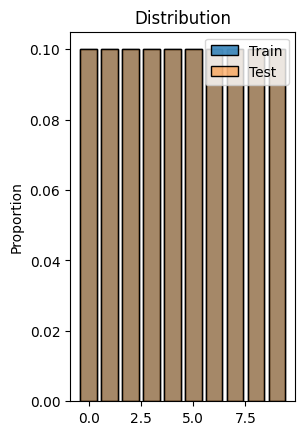

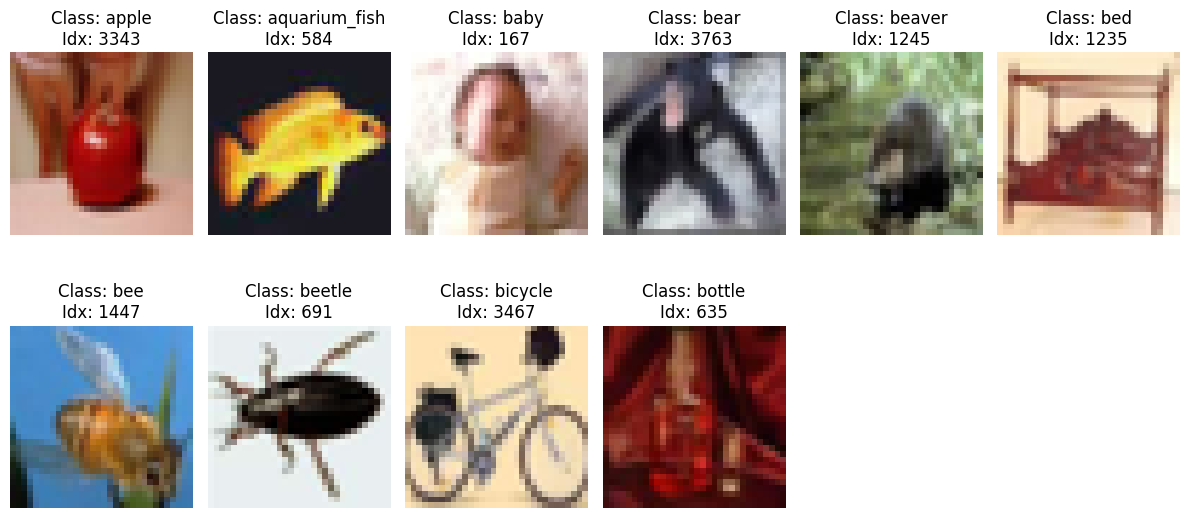

In [ ]:
ds_visu_train = CIFAR100(root='./data_tv', train=True, download=True)
ds_visu_test = CIFAR100(root='./data_tv', train=False, download=True)

x_train_full = ds_visu_train.data        
y_train_full = np.array(ds_visu_train.targets)
x_test_full = ds_visu_test.data
y_test_full = np.array(ds_visu_test.targets)

class_names = ds_visu_train.classes

# On affiche seulement 10 classes pour plus de lisibilité
nb_classes_visu = 10
print(f"Filtrage : Visualisation des {nb_classes_visu} premières classes sur 100.")

# Création des masques pour ne garder que les labels 0 à 9
mask_train = y_train_full < nb_classes_visu
mask_test = y_test_full < nb_classes_visu

# Application du filtre
x_train_sub = x_train_full[mask_train]
y_train_sub = y_train_full[mask_train]
x_test_sub = x_test_full[mask_test]
y_test_sub = y_test_full[mask_test]

# On garde aussi seulement les noms correspondants
class_names_sub = class_names[:nb_classes_visu]

# Appel de la fonction de description
prep.describe_image_dataset(
    x_train_sub, y_train_sub, 
    x_test_sub, y_test_sub, 
    class_names=class_names_sub
)

### 2. Description du modèle ViT
* **Identifiant :** `google/vit-base-patch16-224-in21k`
* **Architecture :** Vision Transformer (ViT) "Base".
* **Pré-entraînement :** Réalisé sur **ImageNet-21k** (14 millions d'images, 21 841 classes), ce qui confère au modèle une capacité de généralisation exceptionnelle pour le transfert d'apprentissage.
* **Résolution d'entrée** | Le modèle est configuré pour des images de **224x224 pixels**.

In [ ]:
train_ds_raw = ds_visu_train
test_ds_raw = ds_visu_test

# On définit 'labels' et les dictionnaires de mapping nécessaires
labels = train_ds_raw.classes
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

print(f"Variables définies : {len(labels)} classes.")
model_checkpoint = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_checkpoint)
model = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


Variables définies : 100 classes.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle et processeur ViT chargés.


In [ ]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
normalize = Normalize(mean=image_mean, std=image_std)

# Transformations 
train_transforms = Compose([
    RandomResizedCrop(size), 
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

# Transformations 
val_transforms = Compose([
    Resize(size), 
    CenterCrop(size),
    ToTensor(),
    normalize,
])

# On doit créer une classe Wrapper pour que Torchvision soit compatible avec ce que le Trainer Hugging Face attend 
class ViTDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        pixel_values = self.transform(image)
        
        return {
            "pixel_values": pixel_values,
            "labels": label
        }

# Création des datasets finaux compatibles Trainer
train_dataset = ViTDatasetWrapper(train_ds_raw, train_transforms)
test_dataset = ViTDatasetWrapper(test_ds_raw, val_transforms)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(labels, predictions))

args = TrainingArguments(
    output_dir="vit_cifar100_output",
    remove_unused_columns=False,
    
    eval_strategy="epoch",          
    
    save_strategy="no",             
    learning_rate=5e-5, # petite lr pour le fine-tuning
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    dataloader_num_workers=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator,
)

trainer.train()


/tmp/ipykernel_3741/1203244196.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Démarrage de l'entraînement...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.498800,1.048239,0.873700
2,0.955500,0.523733,0.906700
3,0.726900,0.425926,0.914000


Terminé ! Modèle sauvegardé.



Notre TrainingArguments définit un logging tous les 50 steps (logging_steps=50), mais une évaluation seulement à chaque époque (eval_strategy="epoch").

- Training Loss : Le Trainer a enregistré ~93 points (un tous les 50 pas de calcul).

- Validation Loss/Acc : Le Trainer a enregistré 3 points (un par époque).

Nous prenons la dernière valeur de la training loss pour comparer à chaque epochs.  

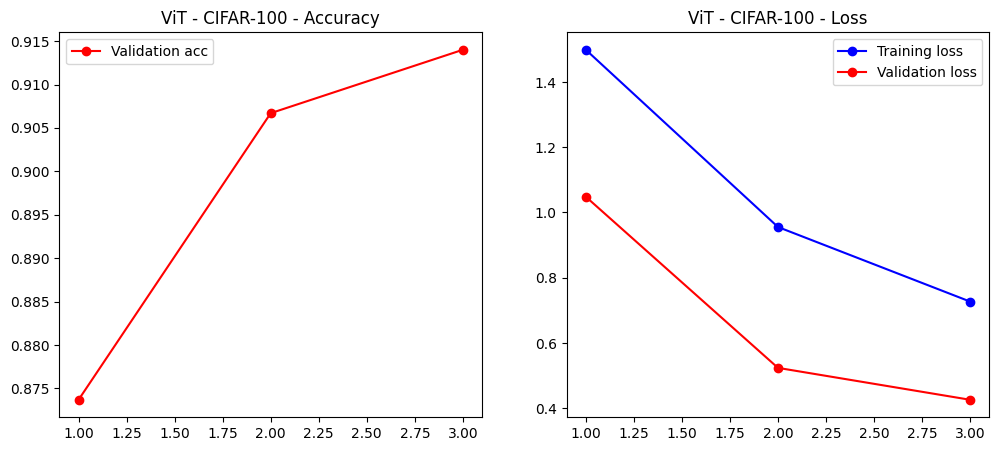

In [31]:
def plot_history(history, title="Training History"):
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(val_acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

df = pd.DataFrame(trainer.state.log_history)

# On récupère les lignes de validation (3 lignes)
eval_df = df.dropna(subset=['eval_loss']).copy()

# On prend la dernière valeur enregistrée pour chaque époque
train_loss_last = (
    df.dropna(subset=['loss'])
    .groupby(df['epoch'].apply(lambda x: int(np.ceil(x))))['loss']
    .last() 
)

history_cifar_vit = {
    'train_loss': train_loss_last.tolist(),
    'val_loss':   eval_df['eval_loss'].tolist(),
    'val_acc':    eval_df['eval_accuracy'].tolist(),
}

plot_history(history_cifar_vit, title="ViT - CIFAR-100")

Par défaut, le Trainer de Hugging Face calcule les métriques (comme l'accuracy) uniquement sur le jeu de données de validation. Nous n'avons pas cherché à calculer l'accuracy pour le jeu d'entraînement, car nous pouvons tirer toutes les conclusions à partir des courbes de validation et des courbes de perte.

 L'analyse des courbes révèle une baisse régulière de la perte, sans aucun signe de surapprentissage (overfitting) du ViT sur CIFAR-100, avec une précision de validation atteignant 91,4 %

## ResNet50

In [ ]:
# On charge ResNet-50 pré-entraîné
# 'DEFAULT' charge les meilleurs poids disponibles (IMAGENET1K_V2)
cnn_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# On doit modifier la dernière couche (la tête) car ImageNet a 1000 classes, 
# et CIFAR-100 en a 100.
num_ftrs = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_ftrs, 100) 

# Wrapper pour rendre le modèle compatible avec Hugging Face Trainer
class HFResNetWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
    
        if torch.cuda.is_available():
            self.model.cuda()

    def forward(self, pixel_values, labels=None):
        
        logits = self.model(pixel_values)
        
        out = {"logits": logits}
        
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            out["loss"] = loss
            
        return out

model_cnn = HFResNetWrapper(cnn_model)

args_cnn = TrainingArguments(
    output_dir="resnet50_cifar100_results",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="no",             
    learning_rate=5e-5,              # Même LR que le ViT pour comparer
    per_device_train_batch_size=16,  # Même batch size
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=6,              # Plus grands nombre d'époques pour CNN car les epochs sont plus rapides
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    dataloader_num_workers=2
)

trainer_cnn = Trainer(
    model=model_cnn,
    args=args_cnn,
    train_dataset=train_dataset,     
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, 
    data_collator=default_data_collator,
)

trainer_cnn.train()

Téléchargement de ResNet-50 (poids ImageNet)
 Démarrage de l'entraînement ResNet-50...


Epoch,Training Loss,Validation Loss,Accuracy
1,2.003300,1.146286,0.666500
2,1.690300,0.856398,0.742700
3,1.504300,0.742203,0.776500
4,1.418900,0.674402,0.796200
5,1.336400,0.641953,0.805900
6,1.304200,0.630225,0.809900


 Modèle ResNet sauvegardé.


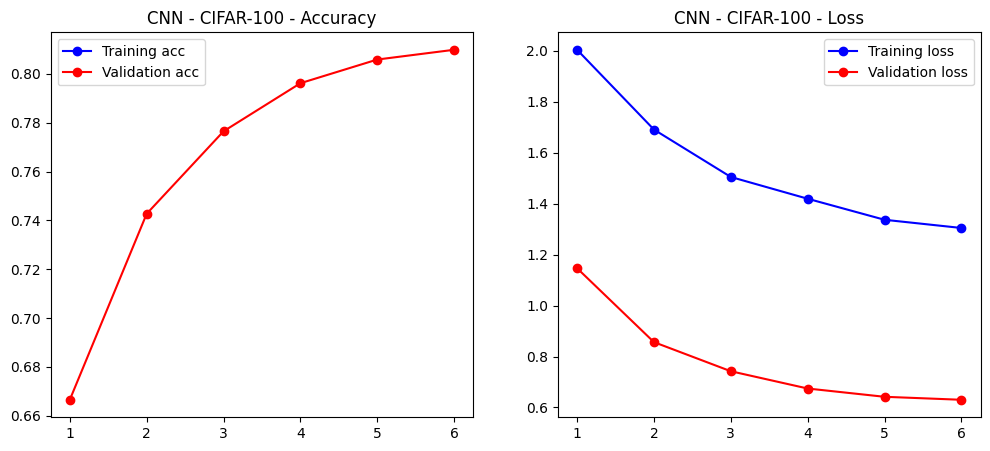

In [27]:
df = pd.DataFrame(trainer_cnn.state.log_history)

eval_df = df.dropna(subset=['eval_loss']).copy()

train_loss_last = (
    df.dropna(subset=['loss'])
    .groupby(df['epoch'].apply(lambda x: int(np.ceil(x))))['loss']
    .last() 
)

history_cifar_cnn = {
    'train_loss': train_loss_last.tolist(),
    'val_loss':   eval_df['eval_loss'].tolist(),
    'val_acc':    eval_df['eval_accuracy'].tolist(),
    'train_acc':  [np.nan] * len(eval_df)
}

plot_history(history_cifar_cnn, title="CNN - CIFAR-100")

De la même manière nous pouvons observer constante augmentation sur 6 époques, atteignant une précision de validation finale de 81 % avec une diminution régulière des pertes, confirmant ainsi une bonne généralisation du modèle malgré des scores inférieurs au ViT

## Comparaison des deux modèles

Nous allons d'abord examiner les courbes de précision de validation des deux modèles pour visualiser les écarts.
Ensuite, nous allons utiliser le framework de comparaison défini précédemment, en l’ajustant légèrement pour qu’il soit adapté à nos deux nouveaux modèles

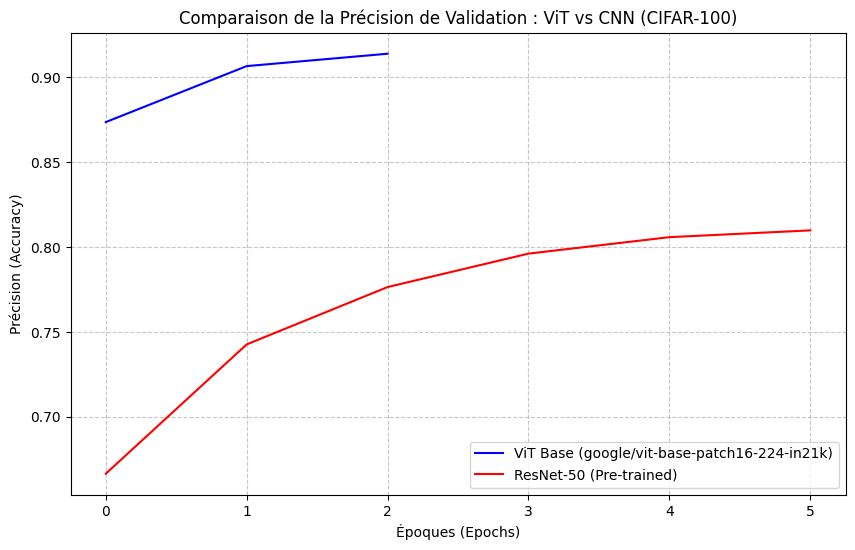

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(history_cifar_vit['val_acc'], 'b-', label='ViT Base (google/vit-base-patch16-224-in21k)')
plt.plot(history_cifar_cnn['val_acc'], 'r-', label='ResNet-50 (Pre-trained)')
plt.title("Comparaison de la Précision de Validation : ViT vs CNN (CIFAR-100)")
plt.xlabel("Époques (Epochs)")
plt.ylabel("Précision (Accuracy)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()

Avec ce graphique, nous observons clairement que le ViT atteint une meilleur accuracy que ResNet, notons le fait que au bout d'une epoch, le ViT affiche déjà 87% d'accuracy ce qui témoigne d'un transfert learning réussi. 

In [32]:
def get_acc(var_name, local_vars):
    if var_name in local_vars:
        # Récupère la dernière valeur de validation (accuracy entre 0 et 1)
        return local_vars[var_name]['val_acc'][-1]
    return 0.0

acc_cnn_cifar = get_acc('history_cifar_cnn', locals())
acc_vit_cifar = get_acc('history_cifar_vit', locals())


print(f"Accuracies (Validation) :")
print(f"  - CNN CIFAR-100 : {acc_cnn_cifar:.2%}")
print(f"  - ViT CIFAR-100 : {acc_vit_cifar:.2%}")


# Dictionnaire des Modèles
models_dict = {
    'CNN_CIFAR100': cnn_model,
    'ViT_CIFAR100': model
}

# Input Shapes )
input_shapes_dict = {
    'CNN_CIFAR100': (1, 3, 32, 32),
    'ViT_CIFAR100': (1, 3, 224, 224) 
}

# Accuracies
accuracies_dict = {
    'CNN_CIFAR100': acc_cnn_cifar,
    'ViT_CIFAR100': acc_vit_cifar,
}

# Temps d'entraînement (en secondes), récuperation manuelle
train_times_dict = {
    'CNN_CIFAR100': 17*60+22,  #  17 minutes 22 secondes
    'ViT_CIFAR100': 16*60+53,   #  16 minutes 53 secondes
}

# Temps de test non mesurés, initialisés à 0, car on n'a pas récupérer les temps de test 
test_times_dict = {k: 0 for k in models_dict.keys()}

results = lib.compare_models(
    models_dict=models_dict,
    input_shapes_dict=input_shapes_dict,
    accuracies_dict=accuracies_dict,
    train_times_dict=train_times_dict,
    test_times_dict=test_times_dict,
    device=device
)


Accuracies (Validation) :
  - CNN CIFAR-100 : 80.99%
  - ViT CIFAR-100 : 91.40%
COMPARAISON DES MODÈLES

Analyse de CNN_CIFAR100...
  Input shape (inférence): (1, 3, 32, 32)
   Test Accuracy: 80.99%
   FLOPs: 0.17 GFLOPs
   Paramètres: 23.71 M
   Mémoire (inférence): 1744.97 MB
   Mémoire (entraînement @batch 32): 1870.23 MB
   Temps d'entraînement: 1042.00s
   Temps de test: 0.00s

Analyse de ViT_CIFAR100...
  Input shape (inférence): (1, 3, 224, 224)
   Test Accuracy: 91.40%
   FLOPs: 33.73 GFLOPs
   Paramètres: 85.72 M
   Mémoire (inférence): 1942.65 MB
   Mémoire (entraînement @batch 32): 3921.31 MB
   Temps d'entraînement: 1013.00s
   Temps de test: 0.00s

TABLEAU RÉCAPITULATIF
Modèle               Input Shape        Acc (%)      FLOPs (G)    Params (M)   Mem Inf (MB)    Mem Train (MB)  Train Time (s)  Test Time (s)  
--------------------------------------------------------------------------------------------------------------------------------------------
CNN_CIFAR100         (1,

## Conclusion 

Ces résultats confirment bien l’observation précédente : un ViT pré-entraîné sur un jeu de données plus important et complexe (ImageNet-21k) affiche de meilleures performances qu’un CNN pré-entraîné sur ImageNet pour un même temps d’entraînement. En revanche, les performances du ViT s’accompagnent d’un coût élevé. Il compte plus de trois fois plus de paramètres, nécessite une puissance de calcul largement supérieure à celle d’un CNN (avec 33,73 milliards d’opérations par seconde) et exige un espace mémoire plus de deux fois supérieur à celui d’un CNN lors de l’entraînement. Cela montre que, même si un ViT surpasse un CNN, il requiert un matériel plus performant et consommera donc plus d’énergie.